# This notebook queries the values in https://ny-idf-projections.nrcc.cornell.edu/
##### Author: Omid Emamjomehzadeh (https://www.omidemam.com/)
##### Supervisor: Dr. Omar Wani (https://engineering.nyu.edu/faculty/omar-wani)
##### Hydrologic Systems Group @NYU (https://www.omarwani.com/)

In [5]:
# import libraries
import pandas as pd
import math
from PyPDF2 import PdfReader
import re
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [6]:
import warnings
# Suppress the specific RuntimeWarning
warnings.filterwarnings("ignore")
# Suppress all UserWarnings, including PerformanceWarnings
warnings.simplefilter('ignore', category=UserWarning)

In [7]:
# path to station charactristics dataset 
reader = PdfReader(r'D:\culvert repo\data\Future Rainfall\idf_tech_document.pdf')
# Initialize combined lists
station_ids, countries, states, names, lats, lons, elevs = [], [], [], [], [], [], []
# Read all pages
reader = PdfReader(r'D:\culvert repo\data\Future Rainfall\idf_tech_document.pdf')
for page_nu in [30, 31, 32, 33]:
    page = reader.pages[page_nu]
    text = page.extract_text()
    long_text = text.replace('\n', ' ')
    pattern = re.compile(
        r'(CA\d+|\d{6})\s+(US|CA)\s+([A-Z]{2})\s+(.*?)\s+([-+]?\d{1,3}\.\d{2})\s+[-−~=]?(\d{1,3}\.\d{2})\s+(\d{1,5})'
    )
    matches = pattern.findall(long_text)
    for match in matches:
        station_ids.append(match[0])
        countries.append(match[1])
        states.append(match[2])
        names.append(match[3])
        lats.append(float(match[4]))
        lons.append(-abs(float(match[5])))  # enforce negative longitudes
        elevs.append(int(match[6]))
# Final DataFrame
station = pd.DataFrame({
    "Station ID": station_ids,
    "Country": countries,
    "State": states,
    "Station Name": names,
    "Lat (°N)": lats,
    "Lon (°E)": lons,
    "Elev (ft)": elevs
})
station

,Station ID,Country,State,Station Name,Lat (°N),Lon (°E),Elev (ft)
0,060806,US,CT,BRIDGEPORT SIKORSKY MEM AP,41.16,-73.13,5
1,061762,US,CT,DANBURY,41.40,-73.42,405
2,062658,US,CT,FALLS VILLAGE,41.95,-73.37,550
3,063207,US,CT,GROTON,41.35,-72.04,40
4,065445,US,CT,NORFOLK 2 SW,41.97,-73.22,1340
...,...,...,...,...,...,...,...
152,CA007025745,CA,QC,ORMSTOWN,45.12,-74.05,150
153,CA007026040,CA,QC,PHILIPSBURG,45.03,-73.08,173
154,CA007026836,CA,QC,ST ANICET 1,45.12,-74.28,154
155,CA007027040,CA,QC,STE CLOTILDE,45.17,-73.68,170


In [8]:
df = pd.read_json(r'D:\culvert repo\data\Future Rainfall\Archive\json_data/KINGSTON.json')

In [9]:
df

,rcp45,rcp85
2010-2039,{'10-yr': {'Projected_10th': [-0.6903746081030...,{'10-yr': {'Projected_10th': [-0.6886637636420...
2070-2099,{'10-yr': {'Projected_10th': [-0.6890079423694...,{'10-yr': {'Projected_10th': [-0.6904876455563...
2040-2069,{'10-yr': {'Projected_10th': [-0.6906611249902...,{'10-yr': {'Projected_10th': [-0.6900310582546...


In [10]:
clicked_return = '100-yr'
clicked_time_per = '2040-2069'
clicked_scenario = 'rcp85'

In [11]:
df[clicked_scenario][clicked_time_per][clicked_return]

{'Projected_10th': [-0.690669094947012, 1.239124783114059],
 'NOAA_Low_CI': [-0.6717905761802351, 0.7606912597587021],
 'NOAA_High_CI': [-0.70138092189189, 1.395229083261764],
 'Projected_90th': [-0.690563811281347, 1.535726137493844],
 'NOAA_Observed': [-0.6836320919487251, 1.071755710154683],
 'NRCC_High_CI': [-0.6904059757505291, 1.254870989120554],
 'Projected_25th': [-0.6912779447178351, 1.2981326578817751],
 'NRCC_Observed': [-0.690359394150808, 1.261064352244347],
 'Projected_75th': [-0.6902045079911371, 1.430370524192433],
 'Projected_Mean': [-0.690371857458378, 1.37469586552894],
 'NRCC_Low_CI': [-0.6898280238126401, 0.985599662852713]}

#### Depth Formula

$$
\text{depth} = \exp\left(\text{first number} \times \log(\text{duration}) + \text{second number}\right)
$$

In [12]:
idf_line = 'Projected_Mean'
duration = 1.0
math.exp(df[clicked_scenario][clicked_time_per][clicked_return][idf_line][0] * math.log(duration) + df[clicked_scenario][clicked_time_per][clicked_return][idf_line][1])

3.953874030652809

In [13]:
# depth of rainfal in inch
for rp in ['2-yr','5-yr','10-yr','25-yr','50-yr','100-yr']:
    for time in ['2010-2039','2040-2069','2070-2099']:
        for scenario in ['rcp45','rcp85']:
            for duration in [1,2,3,6,12,18,24]:
                depth_scenario=[]
                for sta_name in list(station['Station Name']):
                    df = pd.read_json(rf'D:\culvert repo\data\Future Rainfall\Archive\json_data/{sta_name}.json')
                    clicked_return = rp
                    clicked_time_per = time
                    clicked_scenario = scenario
                    depth=math.exp(df[clicked_scenario][clicked_time_per][clicked_return][idf_line][0] * math.log(duration) + df[clicked_scenario][clicked_time_per][clicked_return][idf_line][1])
                    depth=depth*duration
                    #print(f'{sta_name}":"{depth}')
                    depth_scenario.append(depth)
                dur=str(duration)
                station[rp+"_"+time+"_"+scenario+"_"+dur]=depth_scenario
station

,Station ID,Country,State,Station Name,Lat (°N),Lon (°E),Elev (ft),2-yr_2010-2039_rcp45_1,2-yr_2010-2039_rcp45_2,2-yr_2010-2039_rcp45_3,...,100-yr_2070-2099_rcp45_12,100-yr_2070-2099_rcp45_18,100-yr_2070-2099_rcp45_24,100-yr_2070-2099_rcp85_1,100-yr_2070-2099_rcp85_2,100-yr_2070-2099_rcp85_3,100-yr_2070-2099_rcp85_6,100-yr_2070-2099_rcp85_12,100-yr_2070-2099_rcp85_18,100-yr_2070-2099_rcp85_24
0,060806,US,CT,BRIDGEPORT SIKORSKY MEM AP,41.16,-73.13,5,1.485028,1.841016,2.087603,...,8.882938,10.070550,11.008271,4.417691,5.474386,6.206101,7.690578,9.530135,10.803949,11.809708
1,061762,US,CT,DANBURY,41.40,-73.42,405,1.734625,2.149316,2.436447,...,9.724692,11.025448,12.052554,4.802863,5.952129,6.747991,8.362702,10.363793,11.749542,12.843720
2,062658,US,CT,FALLS VILLAGE,41.95,-73.37,550,1.229862,1.523894,1.727483,...,6.741469,7.643596,8.355967,3.333051,4.131050,4.683707,5.805080,7.194932,8.157480,8.917542
3,063207,US,CT,GROTON,41.35,-72.04,40,1.451256,1.798357,2.038706,...,8.619218,9.771479,10.681280,4.273381,5.295847,6.003890,7.440403,9.220621,10.453398,11.426782
4,065445,US,CT,NORFOLK 2 SW,41.97,-73.22,1340,1.423794,1.764132,1.999778,...,7.791655,8.834506,9.658016,3.855777,4.779285,5.418901,6.716797,8.325555,9.439773,10.319631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,CA007025745,CA,QC,ORMSTOWN,45.12,-74.05,150,0.927940,1.149900,1.303598,...,4.897259,5.551132,6.067351,2.420079,2.998204,3.398453,4.210299,5.216085,5.912412,6.462140
153,CA007026040,CA,QC,PHILIPSBURG,45.03,-73.08,173,0.831654,1.030147,1.167550,...,4.401337,4.990359,5.455488,2.202959,2.730185,3.095297,3.836084,4.754161,5.389941,5.891958
154,CA007026836,CA,QC,ST ANICET 1,45.12,-74.28,154,0.922897,1.143953,1.297056,...,4.885579,5.539393,6.055684,2.407771,2.984462,3.383875,4.194355,5.198955,5.894735,6.444169
155,CA007027040,CA,QC,STE CLOTILDE,45.17,-73.68,170,1.081902,1.340897,1.520261,...,5.336541,6.049725,6.612822,2.657947,3.293507,3.733583,4.626347,5.732585,6.498569,7.103344


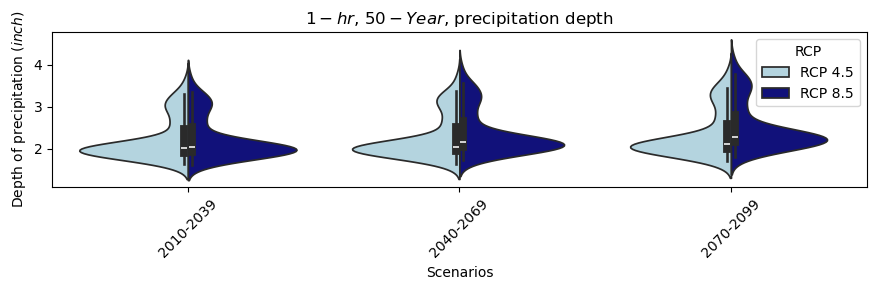

In [27]:
# Sample column names to plot from the DataFrame
columns_to_plot = [
    '50-yr_2010-2039_rcp45_1', '50-yr_2010-2039_rcp85_1',
    '50-yr_2040-2069_rcp45_1', '50-yr_2040-2069_rcp85_1',
    '50-yr_2070-2099_rcp45_1', '50-yr_2070-2099_rcp85_1'
]

# Filter to only columns present in the DataFrame
valid_columns = [col for col in columns_to_plot if col in station.columns]

# Melt the data to long format
station_long = station[valid_columns].melt(var_name='Scenario', value_name='Rainfall')

# Add an RCP label for color grouping
station_long['YearRange'] = station_long['Scenario'].str.extract(r'(\d{4}-\d{4})')
station_long['RCP'] = station_long['Scenario'].apply(lambda x: 'RCP 8.5' if 'rcp85' in x else 'RCP 4.5')

# Define color palette
palette = {
    'RCP 4.5': 'lightblue',
    'RCP 8.5': 'darkblue'
}

# Create the violin plot
plt.figure(figsize=(9, 3))
sns.violinplot(x='YearRange', y='Rainfall', hue='RCP', data=station_long, palette=palette, dodge=True,split=True)
plt.title("$1-hr$, $50-Year$, precipitation depth")
plt.ylabel('Depth of precipitation ($inch$)')
plt.xlabel('Scenarios')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [127]:
# SAVE
station.to_excel(r"D:\culvert repo\data\Future Rainfall\rainfall_station_characteristics.xlsx", index=False)

In [3]:
# Date and time
now = datetime.datetime.now()
print(f"Date and time: {now}")

Date and time: 2025-04-30 17:25:24.003818


In [4]:
%load_ext watermark
# Print the Python version and some dependencies
%watermark -v -m -p pandas,math,PyPDF2,re,matplotlib,seaborn

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.20.0

pandas    : 2.2.2
math      : unknown
PyPDF2    : 3.0.1
re        : 2.2.1
matplotlib: 3.8.4
seaborn   : 0.13.2

Compiler    : MSC v.1940 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
CPU cores   : 24
Architecture: 64bit

